# Introduction

In this notebook we try to build a deep neural network in order to perform ancient british celtic coins classsification with regard to the tribe that made them. In order to do so, we will use and adapt the base approach depicted in  this article : https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2016/media/files/0725.pdf.

 
# Imports and global variables

In [0]:
from torchvision import transforms, models
from torch import utils
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import pandas as pd
import numpy as np
import os
from skimage import io
from PIL import Image
%matplotlib inline

labels = ["Corieltauvi", "Iceni", "Trinovantes-Catuvellauni", "Atrebates", "Cantii", "Durotriges", "Dobunni"]
unknown_labels = ["Blanks", "Uncertain", "Uncertain_British"]
regions = ["East_England", "North_of_the_Thames", "South_of_the_Thames", "South_West_England", "West_England"]
tribe_to_region = {"Corieltauvi":"East_England", "Iceni":"East_England", "Trinovantes-Catuvellauni":"North_of_the_Thames", "Atrebates":"South_of_the_Thames", "Cantii":"South_of_the_Thames", "Durotriges":"South_West_England", "Dobunni":"West_England"}
denominations = ['stater', 'unit', 'quarterstater', 'halfunit', 'minim']
metals = ['gold', 'silver', 'bronze', 'bronzecore', 'silvercore', 'lead']


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [3]:
!git clone https://github.com/jcGourcuff/CelticCoins.git  

Cloning into 'CelticCoins'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 26883 (delta 2), reused 8 (delta 2), pack-reused 26865
Receiving objects: 100% (26883/26883), 220.49 MiB | 43.94 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (26897/26897), done.


In [4]:
%cd CelticCoins

/content/CelticCoins


In [5]:
!ls

CelticCoinsClassifier.ipynb  Images	train.csv
ids_and_labels.csv	     README.md	valid.csv


# Create DataSet

The dataset has been taken from the Celtic Coin Index : http://www.celticcoins.ca/.
It consists of annotated images comprising head and tail for each coin.

We will pass our tails and heads in two separate CNN thus our data samples will be annotated head and tails.
We do not have super class anotations as it is the case in the article, so we will annotate both 

Among others, we will use the Alexnet network so we need to adapt our image in RGB so we can feed them to the network. 


In [0]:
root_dir = "Images/"

class CelcticCoinsDataset(Dataset):

    def __init__(self, csv_file, transform, train_mark = False, n=None):
        self.dataLabels = pd.read_csv(csv_file)
        if train_mark :
          count_region = [np.sum(self.dataLabels['region'] == region) for region in regions]
          m = np.min(count_region)
          print("regions distrib : "+str(count_region))
          if m==0 :
            print("class {} not represented".format(np.argmin(count_region)))
            raise ValueError
          
          indxs = self.dataLabels[self.dataLabels['region'] == regions[0]].index.tolist()
          new_df = self.dataLabels.iloc[np.random.choice(indxs, size = m)].copy()

          for k in range(1, len(regions)):
            indxs = self.dataLabels[self.dataLabels['region'] == regions[k]].index.tolist()
            df = self.dataLabels.iloc[np.random.choice(indxs, size = m)].copy()

            new_df = pd.concat([new_df, df],axis = 0, ignore_index = True)

          self.dataLabels = new_df

          new_df['region'].describe()

        if n is not None : 
          self.dataLabels = self.dataLabels[:n]
        self.transform = transform

    def __len__(self):
        return self.dataLabels.shape[0]

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = root_dir + self.dataLabels.loc[idx,'tribe'] + "/"
        id = str(self.dataLabels.loc[idx, 'id'])
        id = CelcticCoinsDataset.complete_id(id)
        img_name = os.path.join(path, id+".jpg")

        tail, head = self.extract_img(img_name)

        label = self.dataLabels.loc[idx, 'tribe']
        metal = self.dataLabels.loc[idx, 'metal']
        denomination = self.dataLabels.loc[idx, 'denomination']
        region = self.dataLabels.loc[idx, 'region']
        sample = {'tail': tail, 'head': head, 'label': label, 'metal':metal, 'denomination':denomination, 'region':region, 'img_name':img_name}

        return sample

    @staticmethod
    def complete_id(str):
        a = str
        n = 6 - len(a)
        for i in range(n) : a = '0'+a
        return a

    def extract_img(self, img_name):
          try:
              img = Image.open(img_name) # open the image file
              img.verify() # verify that it is, in fact an image
              img.close()
          except (IOError, SyntaxError) as e:
              print('Bad file:', img_name)
          img =  io.imread(img_name,plugin='matplotlib', as_gray =True).astype(np.uint8)
          
          split = np.split(img,[img.shape[1]//2],axis=1)
          tail = self.transform(split[0])
          tail = torch.as_tensor(tail)
          head = self.transform(split[1])
          head = torch.as_tensor(head)
          return tail, head

In [7]:
labels_enc = LabelBinarizer()
labels_enc.fit(labels)

regions_enc = LabelBinarizer()
regions_enc.fit(regions)

metals_enc = LabelBinarizer()
metals_enc.fit(metals)


denominations_enc = LabelBinarizer()
denominations_enc.fit(denominations)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

Now we want to use a pretrained model : Resnet. Thus we need to adapt our dataset.

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_RGB = transforms.Lambda(lambda x: x.expand(3, -1, -1) )
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                to_RGB,
                                normalize])

Now we can create the datasets train and valid and feed them to dataloaders.

In [9]:
train = CelcticCoinsDataset("train.csv", transform = transform, train_mark = True)
valid = CelcticCoinsDataset("valid.csv", transform = transform)

print("train set size = "+str(len(train)))

batch_size_ = 1

test_loader = utils.data.DataLoader(train, batch_size = 64, shuffle=True, num_workers = 1)
train_dataSet = utils.data.DataLoader(train, batch_size = batch_size_, shuffle=True, num_workers = 1)
valid_dataSet = utils.data.DataLoader(valid, batch_size = batch_size_, shuffle=False, num_workers = 1)

regions distrib : [6546, 5109, 5307, 3424, 1051]
train set size = 5255


Finally we create a function to display images.

In [0]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    plt.figure(figsize=(24,48))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

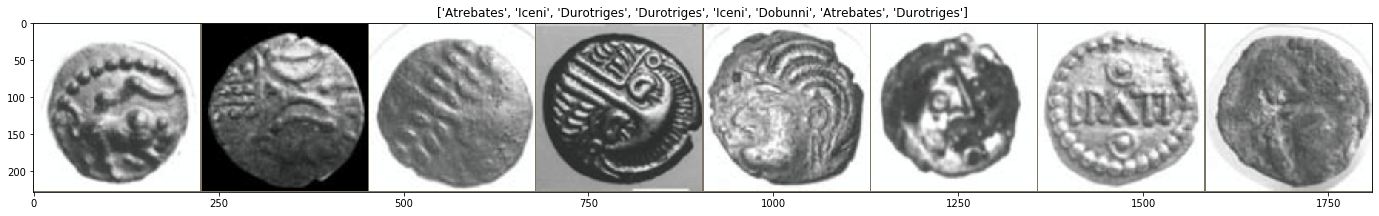

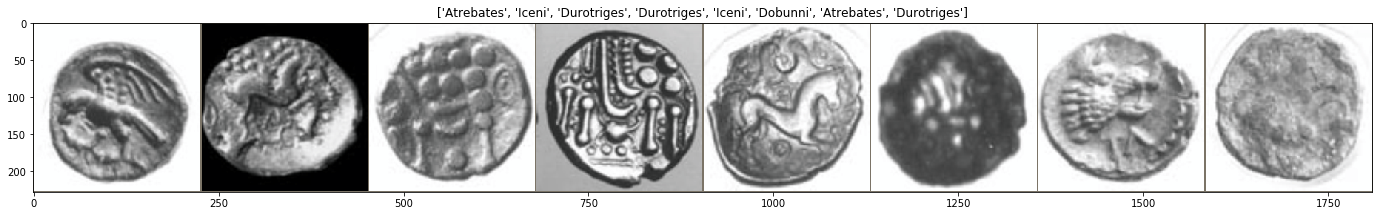

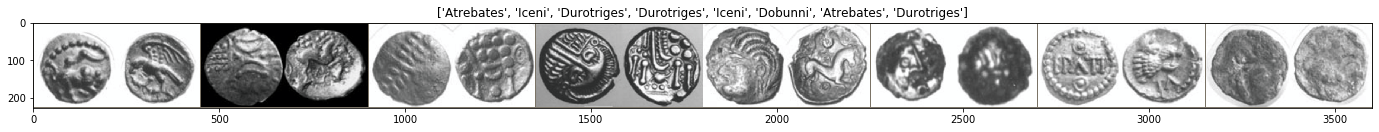

In [12]:
batch_test = next(iter(test_loader))
n_images = 8
tails, heads = batch_test['tail'], batch_test['head'] 

tails_grid = torchvision.utils.make_grid(tails[0:n_images])
imshow(tails_grid, title=[x for x in batch_test['label'][0:n_images]])

heads_grid = torchvision.utils.make_grid(heads[0:n_images])
imshow(heads_grid, title=[x for x in batch_test['label'][0:n_images]])

a= [torch.cat([a,b], axis =2) for a,b in zip(tails[0:n_images],heads[0:n_images])]
out = torchvision.utils.make_grid(a)
imshow(out, title=[x for x in batch_test['label'][0:n_images]])

# Model instanciation

In [0]:
class ClassifImg(nn.Module):
  def __init__(self):
        super(ClassifImg, self).__init__()
        self.classifier_1 = torchvision.models.resnet50(pretrained = True)
        for param in self.classifier_1.parameters():
          param.requires_grad = False
        self.classifier_1.fc = nn.Sequential(nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=2048, out_features= 1024),
                                        nn.ReLU(inplace = True))
                                        
        
        self.classifier_2 = torchvision.models.resnet50(pretrained = True)
        for param in self.classifier_2.parameters():
          param.requires_grad = False
        self.classifier_2.fc = nn.Sequential(nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=2048, out_features= 1024),
                                        nn.ReLU(inplace = True))
        
        self.classifimg = nn.Sequential(nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=2048, out_features=2048),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=2048, out_features=1024),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=1024, out_features=1024),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=1024, out_features=512),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=512, out_features=256),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=256, out_features=64),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=64, out_features=64),
                                        nn.ReLU(inplace = True))
        
        self.fc = nn.Sequential(nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=64, out_features= 5))
        
  def forward(self, tail, head):

    tail = self.classifier_1(tail)
    head = self.classifier_2(head)
    img = torch.cat((tail,head),dim=1)
    img = self.classifimg(img)

    return self.fc(img)


class CoinNet(nn.Module):

  def __init__(self, class_img):
        super(CoinNet, self).__init__()

        self.img_classif = class_img
        class_img.fc = nn.Sequential(nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=256, out_features=64))

        self.tribe_classif = nn.Sequential(nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=75, out_features= 75),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=75, out_features=32),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=132, out_features=32),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=16, out_features=16),
                                        nn.ReLU(inplace = True))
        
        self.fc = nn.Sequential(nn.Dropout(p=0.5, inplace = False),
                                        nn.Linear(in_features=16, out_features= 7))
        
        
  def forward(self,tail,head,feats):
        img = self.img_classif(tail,head)
        x = torch.cat((img,feats),dim=1)
        x = self.tribe_classif(x)
        return self.fc(x)
          
  

In [0]:
Image_classifier = ClassifImg().to(device)

In [0]:
from torch.autograd import Variable
import cv2

class CamExtractor():
    """
        Extracts cam features from the model
    """

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients1 = None
        self.gradients2 = None

    def save_gradient1(self, grad):
        self.gradients1 = grad

    def save_gradient2(self, grad):
        self.gradients2 = grad

    def forward_pass_on_convolutions(self, x1, x2):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output1, conv_output2 = None, None
        for module_name, module in self.model.classifier_1._modules.items() :
              if module_name == 'fc':
                break
              x1 = module(x1)
              
              if module_name == self.target_layer:
                x1.register_hook(self.save_gradient1)
                conv_output1 = x1  

        for module_name, module in self.model.classifier_2._modules.items() :
              if module_name == 'fc':
                return conv_output1, conv_output2, x1, x2

              x2 = module(x2)

              if module_name == self.target_layer:
                x2.register_hook(self.save_gradient2)
                conv_output2 = x2  

        return conv_output1, conv_output2, x1, x2

    def forward_pass(self, x1, x2):
        
        conv_output1, conv_output2, x1, x2 = self.forward_pass_on_convolutions(x1,x2)
        x1 = x1.view(x1.size(0), -1) 
        x2 = x2.view(x2.size(0), -1) 
        x1 = self.model.classifier_1.fc(x1)
        x2 = self.model.classifier_2.fc(x2)
        x = torch.cat((x1,x2),dim=1)
        x = self.model.classifimg(x)
        x = self.model.fc(x)
        
        return conv_output1, conv_output2, x

class GradCam():

    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image1, input_image2, target_index=None):

        conv_output1, conv_output2, model_output = self.extractor.forward_pass(input_image1, input_image2)
        if target_index is None:
            target_index = np.argmax(model_output.data.numpy())
        
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_index] = 1
        
        self.model.fc.zero_grad()
        self.model.classifier_1.fc.zero_grad()
        self.model.classifier_2.fc.zero_grad()
        self.model.classifimg.zero_grad()
       
        model_output.backward(gradient=one_hot_output.to(device), retain_graph=True)
      
        guided_gradients1 = self.extractor.gradients1.data.cpu().numpy()[0]
        guided_gradients2 = self.extractor.gradients2.data.cpu().numpy()[0]

        target1 = conv_output1.data.cpu().numpy()[0]
        target2 = conv_output2.data.cpu().numpy()[0]

        weights1 = np.mean(guided_gradients1, axis=(1, 2))

        cam1 = np.ones(target1.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights1):
            cam1 += w * target1[i, :, :]
        cam1 = cv2.resize(cam1, (224, 224))
        cam1 = np.maximum(cam1, 0)
        cam1 = (cam1 - np.min(cam1)) / (np.max(cam1) - np.min(cam1))  
        cam1 = np.uint8(cam1 * 255) 
        
        weights2 = np.mean(guided_gradients2, axis=(1, 2))

        cam2 = np.ones(target2.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights1):
            cam2 += w * target2[i, :, :]
        cam2 = cv2.resize(cam2, (224, 224))
        cam2 = np.maximum(cam2, 0)
        cam2 = (cam2 - np.min(cam2)) / (np.max(cam2) - np.min(cam2)) 
        cam2 = np.uint8(cam2 * 255)
      
        return cam1, cam2

def preprocess_image(img, resize_im=True):

    im_as_ten = img

    im_as_ten.unsqueeze_(0)

    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def get_activation_on_image(org_img, activation_map):

    activation_heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_HSV)

    org_img = cv2.resize(org_img, (224, 224))
    img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
    path_to_file = os.path.join('./results', file_name + '_Cam_On_Image.jpg')
    return np.uint8(255 * img_with_heatmap)

    

First we train the image classifier with region labels.

# Training loop

In [0]:

F = nn.Sigmoid().to(device)

loss_fn = nn.BCEWithLogitsLoss().to(device)

lr_ = 0.001
momentum_ = 0.9

optimizer = torch.optim.SGD(Image_classifier.parameters(), lr=lr_, momentum=momentum_)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3*train.dataLabels.shape[0]//batch_size_, gamma=.1, last_epoch=-1)

In [0]:
def train_model(model,dataloader, size, batch_size, optimizer, scheduler=None, epochs=1, target = 'tribe'):  

    model.train() 

    epoch_losses=[]
    batch_losses=[]
    epoch_accs = []
    batch_accs = []
    
    for epoch in range(epochs):
        loader_iter = iter(dataloader)
        running_loss = 0.0
        running_corrects = 0.0
        
        while(True):
            try :
              batch = next(loader_iter)
            except StopIteration : 
              break

            batch_loss = 0.0
            batch_corrects = 0

            tail, head = batch['tail'].to(device), batch['head'].to(device)
            metal = torch.FloatTensor(metals_enc.transform(batch['metal'])).to(device)
            denomination = torch.FloatTensor(denominations_enc.transform(batch['denomination'])).to(device)
            feats = torch.cat((metal,denomination), dim = 1).to(device)
            
            classes, outputs = None, None
            if target == 'tribe':
              classes = torch.FloatTensor(labels_enc.transform(batch['label'])).to(device)
              outputs = model(tail, head, feats)
            else :
              classes = torch.FloatTensor(regions_enc.transform(batch['region'])).to(device)
              outputs = model(tail, head)
            
            loss = loss_fn(outputs, classes)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            

            if scheduler is not None :
              scheduler.step()
            
            _, preds = torch.max(F(outputs),1)
            _, classes =  torch.max(classes,1)
            
            l = loss.data.item()
            cor = torch.sum(preds == classes)

            running_loss += float(l)
            running_corrects += float(cor)
            
            if batch_size > 1 :
              batch_loss += l / batch_size
              batch_acc = cor/ batch_size
              batch_losses.append(batch_loss)
              batch_accs.append(batch_acc)


        epoch_loss = running_loss / size
        epoch_acc = running_corrects/ size
        epoch_accs.append(epoch_acc)
        epoch_losses.append(epoch_loss)
        print('epoch: {} Loss: {:.4f} Corrects : {}/{} Acc: {:.4f}'.format(epoch, epoch_loss, running_corrects, size, epoch_acc))
    return epoch_losses, batch_losses, epoch_accs , batch_accs 
    
    
    

First we train the first classifier : 

In [0]:
epoch_losses, batch_losses, epoch_accs , batch_accs = train_model(Image_classifier,train_dataSet, size = train.dataLabels.shape[0], batch_size = batch_size_, optimizer = optimizer, scheduler = scheduler, epochs =10, target = 'region')

KeyboardInterrupt: ignored

In [0]:
def plot_curve(data ,title = 'no title'):
  Y = np.array(data)
  X = np.arange(len(Y))+np.ones(len(Y))
  plt.figure(figsize=(10,8))
  plt.plot(X,Y)
  plt.title(title)
  plt.xlabel("nb_iter")
  plt.ylabel("value")
  plt.show()

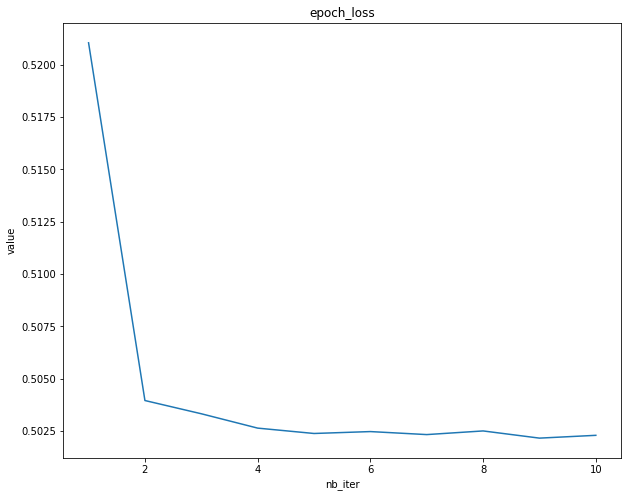

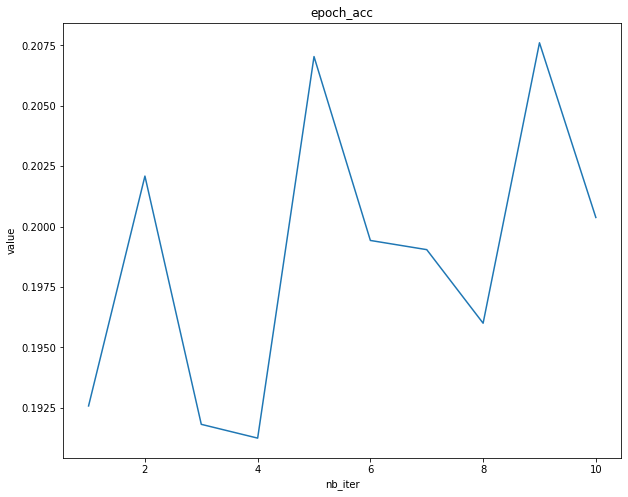

In [0]:
plot_curve(epoch_losses, "epoch_loss")
plot_curve(epoch_accs, "epoch_acc")
if batch_size_ > 1:
  plot_curve(batch_losses, "batch_loss")
  plot_curve(batch_accs, "batch_acc")

Then we freeze all of his params :

In [0]:
Image_classifier.eval()

ClassifImg(
  (classifier_1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

And we instanciate the "real" classifier

# Evaluation

In [0]:
def test_model(model, dataloader, size, batch_size, epochs=1, target = 'tribe'):
    model.eval()

    batch_losses=[]
    batch_accs = []

    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,5))
    if target == 'tribe' :
      all_proba = np.zeros((size,5))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    loader_iter = iter(dataloader)
      
    while(True):
        try :
          batch = next(loader_iter)
        except StopIteration : 
          break

        batch_loss = 0.0
        batch_corrects = 0

        tail, head = batch['tail'].to(device), batch['head'].to(device)
        metal = torch.FloatTensor(metals_enc.transform(batch['metal'])).to(device)
        denomination = torch.FloatTensor(denominations_enc.transform(batch['denomination'])).to(device)
        feats = torch.cat((metal,denomination), dim = 1).to(device)
        
        classes, outputs = None, None
        if target == 'tribe':
          classes = torch.FloatTensor(labels_enc.transform(batch['label'])).to(device)
          outputs = model(tail, head, feats)
        else :
          classes = torch.FloatTensor(regions_enc.transform(batch['region'])).to(device)
          outputs = model(tail, head)

        
        
        loss = loss_fn(outputs,classes)
        
        _, preds = torch.max(F(outputs),1)
        _, classes =  torch.max(classes,1)
        l = loss.to('cpu').data.item()
        cor = torch.sum(preds == classes)

        running_loss += l
        running_corrects += float(cor)

        batch_loss = l / batch_size
        batch_acc = cor/ batch_size
        batch_losses.append(batch_loss)
        batch_accs.append(batch_acc)

        gap = classes.shape[0]
        predictions[i:i+gap] = preds.to('cpu').numpy()
        all_classes[i:i+gap] = classes.to('cpu').numpy()
        all_proba[i:i+gap,:] = outputs.data.to('cpu').numpy()
        i += gap


    epoch_loss = running_loss / size
    epoch_acc = running_corrects/ size
    print('Loss: {:.4f} Corrects : {}/{} Acc: {:.4f}'.format(epoch_loss, running_corrects, size, epoch_acc))

    return batch_losses, batch_accs, predictions, all_proba, all_classes

In [0]:
batch_losses, batch_accs, predictions, all_proba, all_classes = test_model(Image_classifier,valid_dataSet,size=valid.dataLabels.shape[0], batch_size = batch_size_, target = 'region')

Loss: 0.5005 Corrects : 1281.0/5360 Acc: 0.2390


In [0]:
from numpy.random import random, permutation
import torchvision.transforms.functional as TF

n_view = 8

In [0]:
def show_heat_maps(model, tails, heads, target_layer):

  grad_cam = GradCam(model.to(device) , target_layer= target_layer)

  cam_tails, cam_heads =[],[]
  for tail, head in zip(tails, heads):
    tail = preprocess_image(tail).to(device)
    head = preprocess_image(head).to(device)
    cam1, cam2 = grad_cam.generate_cam(tail, head, 0)
    cam_tails.append(cam1)
    cam_heads.append(cam2)

  for a,b in zip(cam_tails, cam_heads):
    plt.subplot(1,2,1)
    plt.imshow(a)

    plt.subplot(1,2,2)
    plt.imshow(b)

    plt.show()


  """a= [torch.cat([torch.as_tensor(a),torch.as_tensor(b)], axis =2) for a,b in zip(cam_tails,cam_heads)]
  out = torchvision.utils.make_grid(a)
  imshow(out, title=[x for x in batch_test['label'][0:len(tails)]])"""




In [0]:
def get_stats(model, prediction, all_prob, all_classe, dataset, target_layer = 'conv1'):

  for k,name in enumerate(regions):
    print("REGION "+name, end = '\n')
    total =  np.where((all_classe==k))[0]
    corrects = np.where((prediction==k) & (prediction==all_classe))[0]
    wrongs = np.where((all_classe==k) & (prediction!=all_classe))[0]

    false_pos = np.where((all_classe!=k) & (prediction==k))[0]
    precision = np.sum(corrects)/(np.sum(false_pos) + np.sum(corrects))

    false_neg = np.where((all_classe==k) & (prediction!=k))[0]
    recall =  np.sum(corrects)/(np.sum(false_neg) + np.sum(corrects))

    F1 = 2*recall*precision/(recall+precision)

    print("GENERAL STATS", end = '\n')

    print("Corrects : {}/{} Precision : {} Recall : {} F1 : {}".format(np.sum(corrects), np.sum(total), precision, recall, F1))

    print("most corrects")
    most_corrects = np.argsort(all_prob[corrects,k])[:n_view]
    a= [torch.cat([dataset[i]['tail'],dataset[i]['head']], axis =2) for i in most_corrects]
    if len(a) == 0 :
      print("Warning : no good prediction for this region.")
    else :
      out = torchvision.utils.make_grid(a)
      imshow(out, title=[dataset[i]['label'] for i in most_corrects])

      print('\n')

      show_heat_maps(model,[dataset[i]['tail'] for i in most_corrects], [dataset[i]['head'] for i in most_corrects], target_layer )



    print('\n')

    print("most wrong")
    most_wrongs = np.argsort(all_prob[wrongs,k])[-n_view:]
    a= [torch.cat([dataset[i]['tail'],dataset[i]['head']], axis =2) for i in most_wrongs]
    if len(a) == 0 :
      print("Warning : no wrong prediction for this region.")
    else :
      out = torchvision.utils.make_grid(a)
      imshow(out, title=[dataset[i]['label'] for i in most_wrongs])

      print('\n')

      show_heat_maps(model,[dataset[i]['tail'] for i in most_wrongs], [dataset[i]['head'] for i in most_wrongs], target_layer)

    print('\n')

    print("less wrong")
    less_wrongs = np.argsort(all_prob[wrongs,k])[:n_view]
    a= [torch.cat([dataset[i]['tail'],dataset[i]['head']], axis =2) for i in less_wrongs]
    if len(a) == 0 :
      print("Warning : no wrong prediction for this region.")
    else :
      out = torchvision.utils.make_grid(a)
      imshow(out, title=[dataset[i]['label'] for i in less_wrongs])

      print('\n')

      show_heat_maps(model,[dataset[i]['tail'] for i in less_wrongs], [dataset[i]['head'] for i in less_wrongs], target_layer)

    print('\n')

  






REGION East_England
GENERAL STATS
Corrects : 0/1296855 Precision : nan Recall : 0.0 F1 : nan
most corrects


most wrong


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


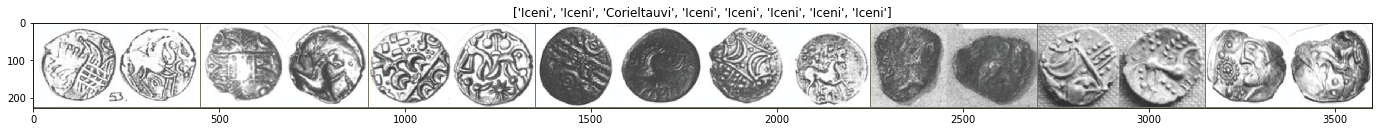

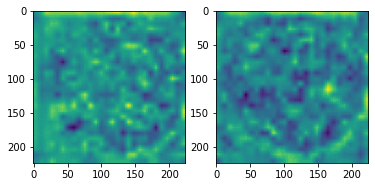

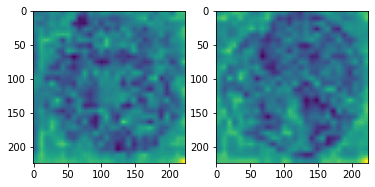

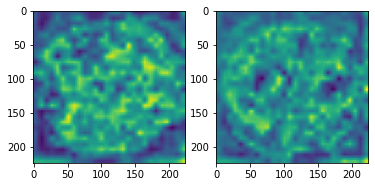

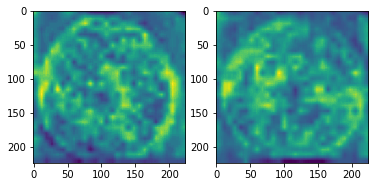

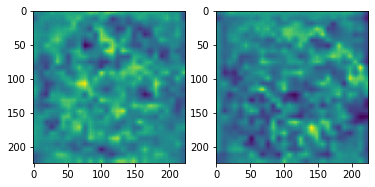

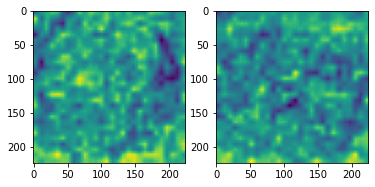

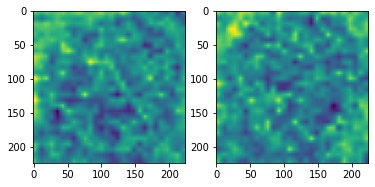

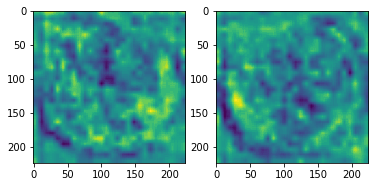



less wrong


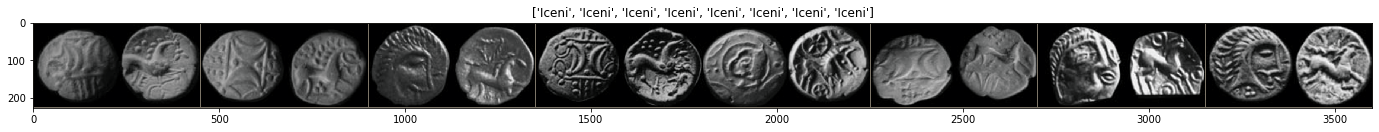

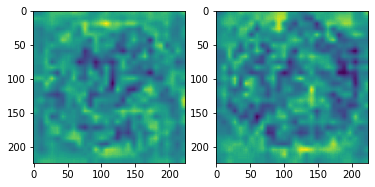

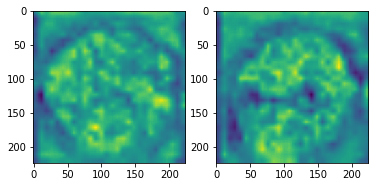

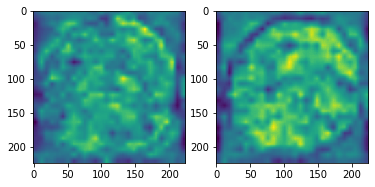

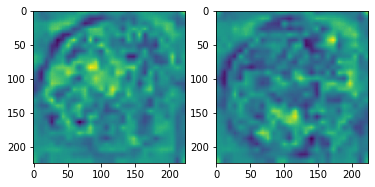

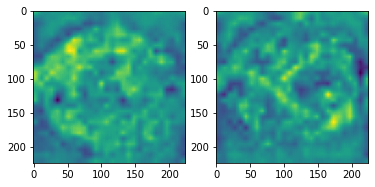

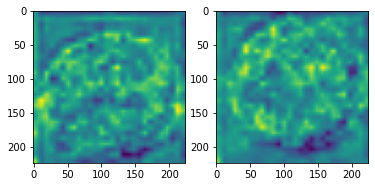

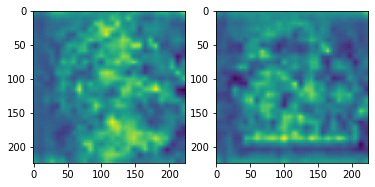

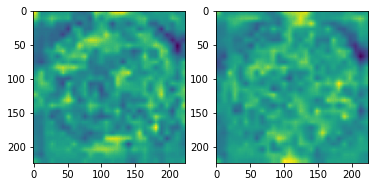



REGION North_of_the_Thames
GENERAL STATS
Corrects : 2883531/2883531 Precision : 0.20077335379456515 Recall : 1.0 F1 : 0.33440674405390675
most corrects


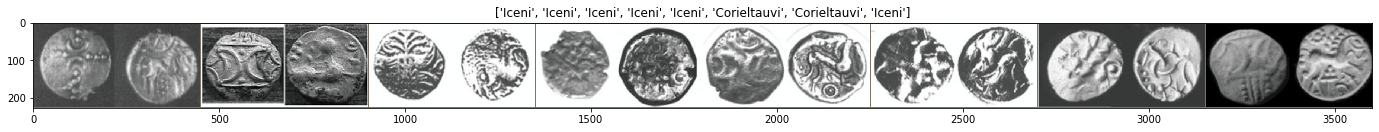

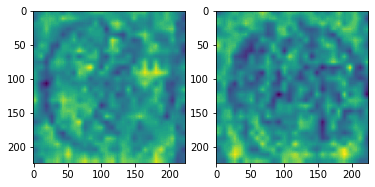

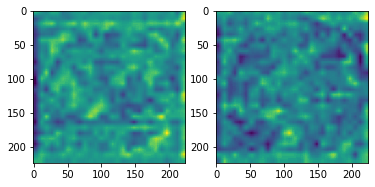

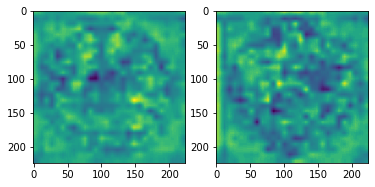

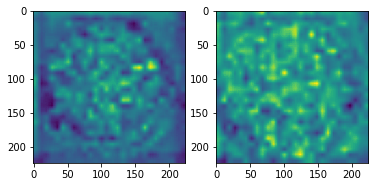

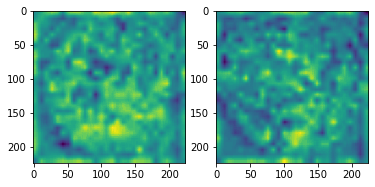

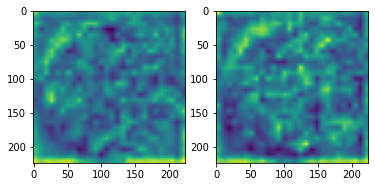

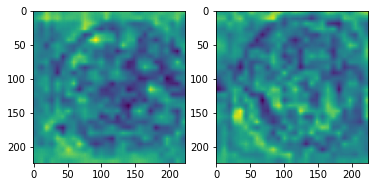

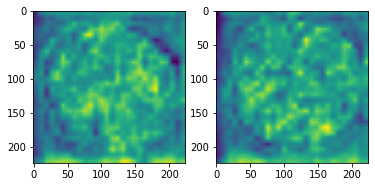



most wrong


less wrong


REGION South_of_the_Thames
GENERAL STATS
Corrects : 0/4105950 Precision : nan Recall : 0.0 F1 : nan
most corrects


most wrong


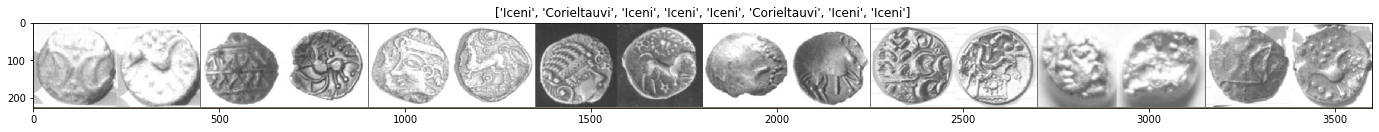

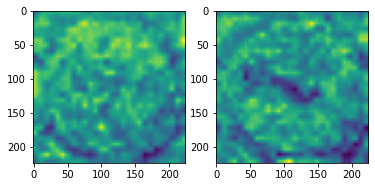

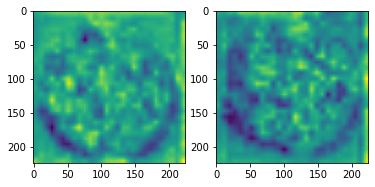

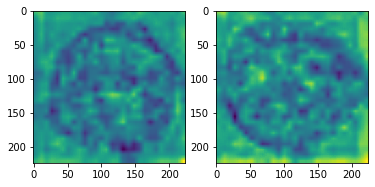

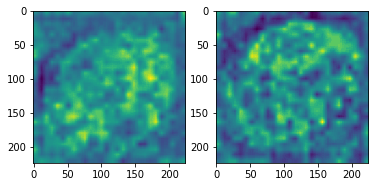

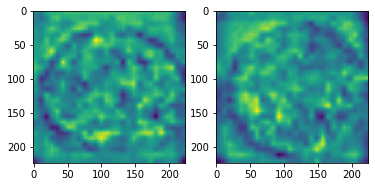

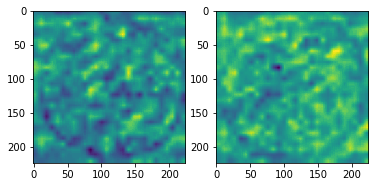

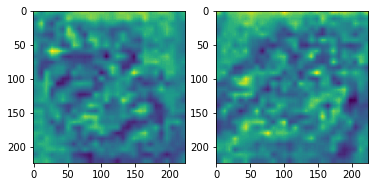

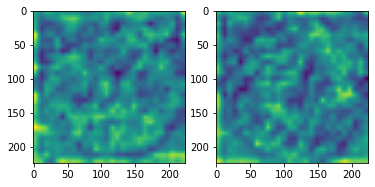



less wrong


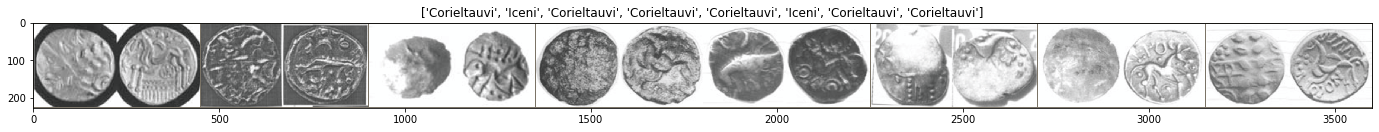

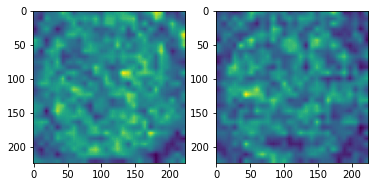

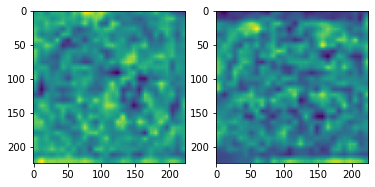

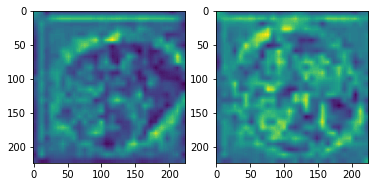

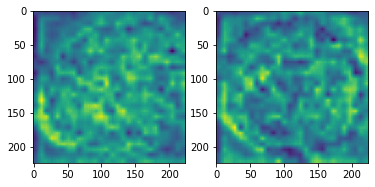

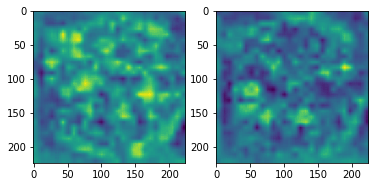

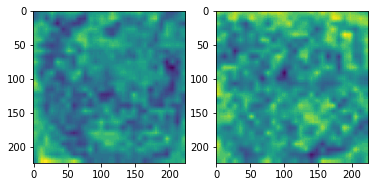

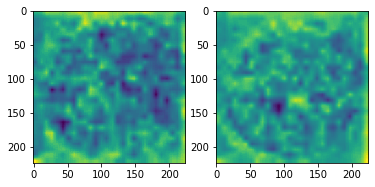

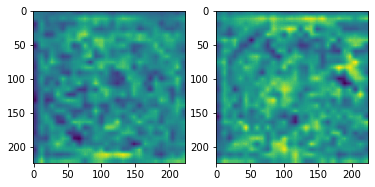



REGION South_West_England
GENERAL STATS
Corrects : 0/4675350 Precision : nan Recall : 0.0 F1 : nan
most corrects


most wrong


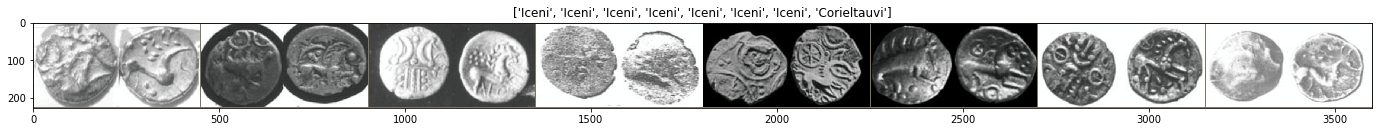

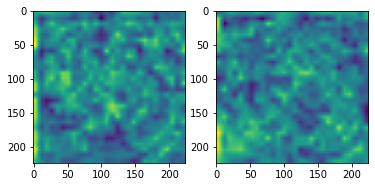

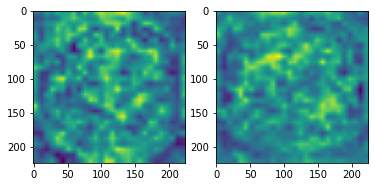

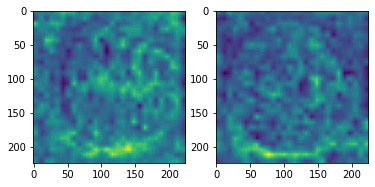

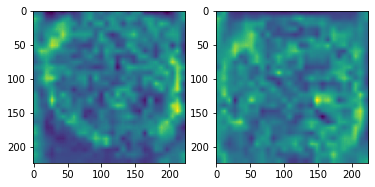

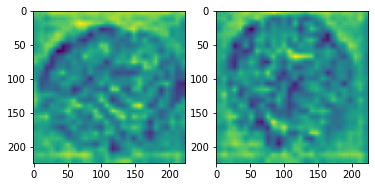

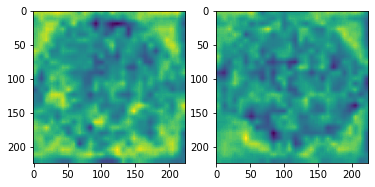

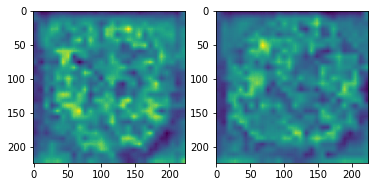

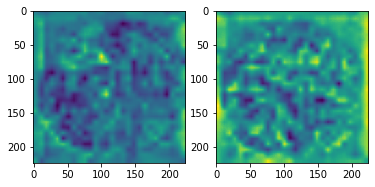



less wrong


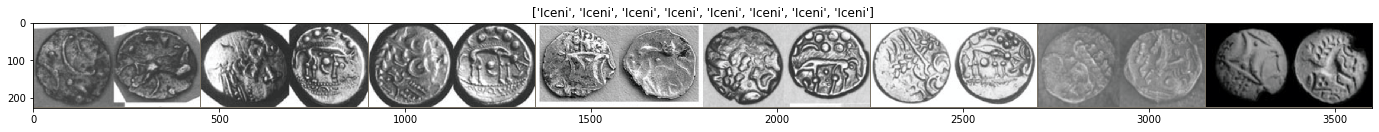

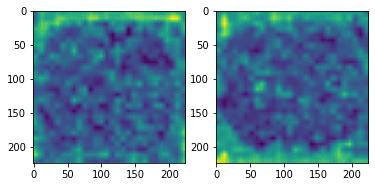

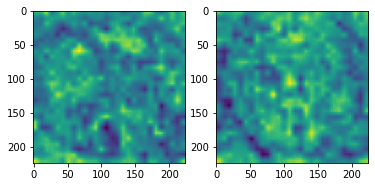

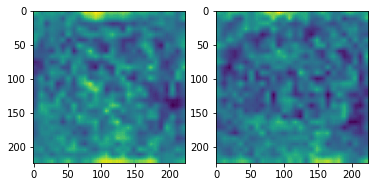

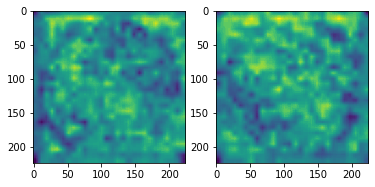

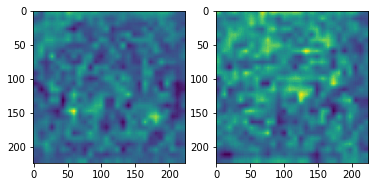

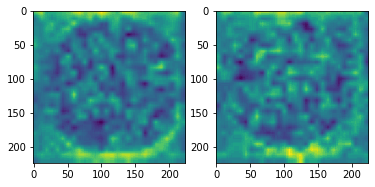

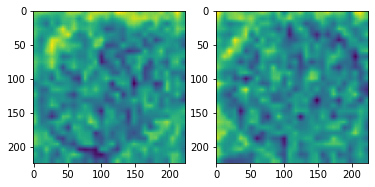

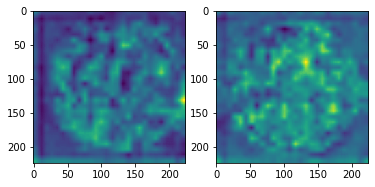



REGION West_England
GENERAL STATS
Corrects : 0/1400434 Precision : nan Recall : 0.0 F1 : nan
most corrects


most wrong


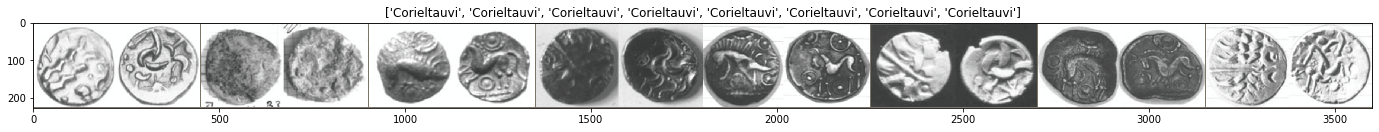

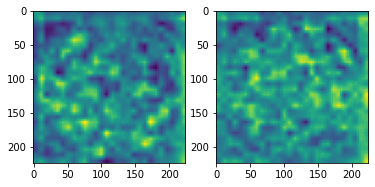

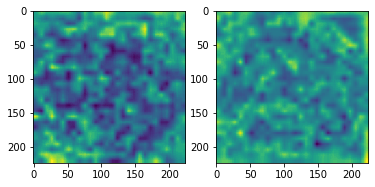

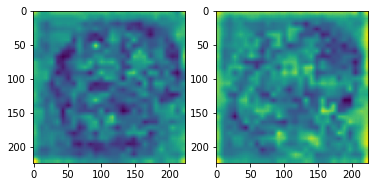

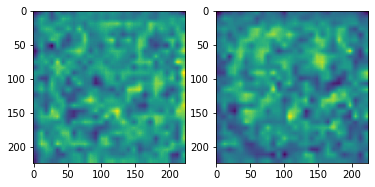

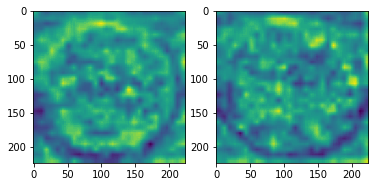

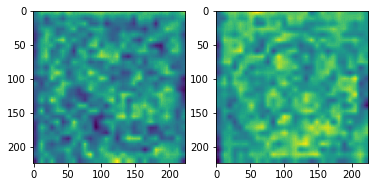

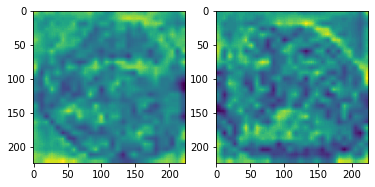

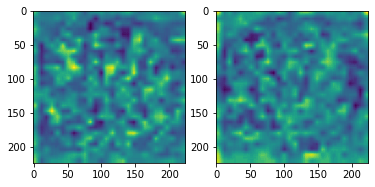



less wrong


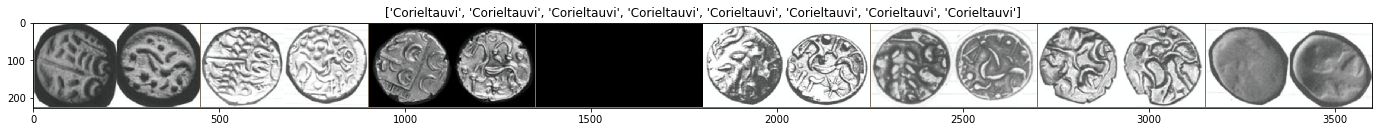

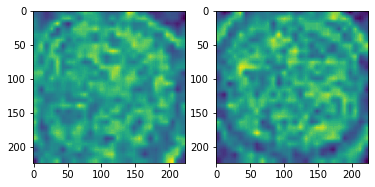

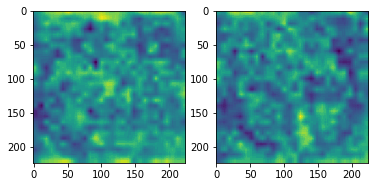

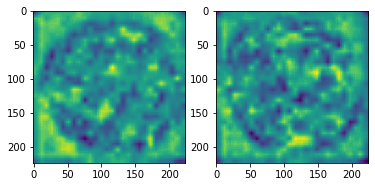

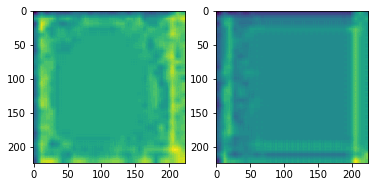

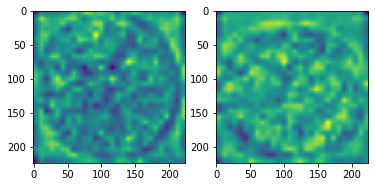

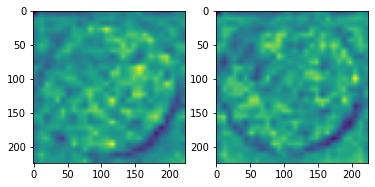

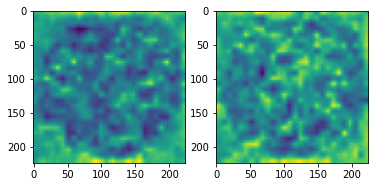

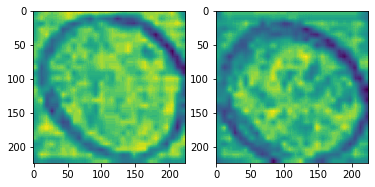

In [0]:
get_stats(Image_classifier, predictions, all_proba, all_classes, valid, 'layer2')